In [1]:
from Models.BaseCNN import BaseCNN
from Models.ResNet18 import ResNet18
from Models.EfficientNet_V2_S import EfficientNet_V2_S
from Models.VGG11_bn import VGG11_bn
from train_eval import trainNN, validateNN, train_and_validateNN, testNN
# from earlystop import EarlyStopper
from processes import initModel, trainModel, loadModel, plotTrain, saveModel, confMtx
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

## **Data Preparation**

In [2]:
# Read in data
img_size = 64
data_transformation = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root='lung_colon_image_set', transform=data_transformation)

In [3]:
dataset.class_to_idx

{'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}

In [4]:
# Set up train and test data
train_size = int(0.7 * len(dataset))
valid_size = int(0.2 * len(dataset))
test_size = int(0.1 * len(dataset))
train_data, valid_data, test_data = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

batch_size = 32  
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

len(train_data), len(valid_data), len(test_data)

(17500, 5000, 2500)

In [5]:
# 'Colon Adenocarcinoma', 'Colon Benign', 'Lung Adenocarcinoma', 'Lung Benign', 'Lung Squamous Cell Caricnoma'
classes = ('colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc')
#classes = ('lung_aca', 'lung_n', 'lung_scc')
# The function to show an image.
def display_img(ax, img, label):
    img = np.transpose(img.numpy(), (1, 2, 0))  # Change from (C,H,W) to (H,W,C)
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])
    img = stds * img + means  # Apply the reverse of normalization     # Unnormalize.
    img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1
    ax.imshow(img)
    ax.set_title(classes[label])
    ax.axis('off')

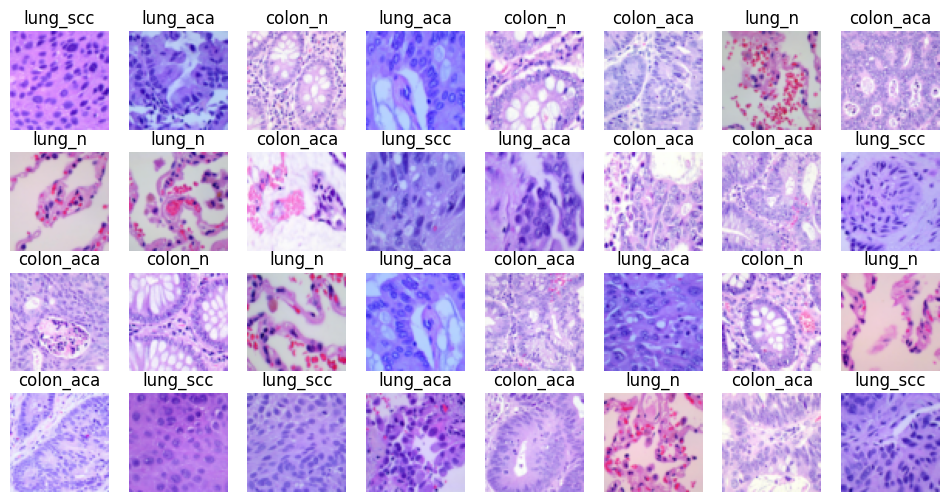

In [6]:
plt.figure(figsize=(12, 6))

# Get a random batch of training images.
images, labels = next(iter(train_loader))

for i in range(batch_size):
    ax = plt.subplot(4, 8, i+1)  # Create a subplot for each image
    display_img(ax, images[i], labels[i])

In [7]:
# Set up device
if torch.backends.mps.is_available(): # M1 Mac
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)  

cuda


## **Set Up Training and Validation Steps**

In [8]:
num_epochs = 5
criterion = nn.CrossEntropyLoss()
lr = 0.001

In [9]:
def w_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, 0, .02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1, .02)
        nn.init.constant_(m.bias.data, 0)

### ReLU + MaxPool

In [10]:
model1 = initModel('relu', 'max', img_size, device, elu_val = 1, lrelu_val = .01)
model1.apply(w_init)
optimizer1 = optim.Adam(model1.parameters(), lr = lr)
train_loss1, valid_loss1 = trainModel(model1, 'relu', 'max', img_size, train_loader, valid_loader, criterion, optimizer1, num_epochs, device)

[Epoch 1/5]
Mini-batch (i: 100): Average mini-batch loss: 0.652
Mini-batch (i: 200): Average mini-batch loss: 0.493
Mini-batch (i: 300): Average mini-batch loss: 0.433
Mini-batch (i: 400): Average mini-batch loss: 0.412
Mini-batch (i: 500): Average mini-batch loss: 0.397
End of Epoch 1 - train loss: 0.4678, valid loss: 0.3749
[Epoch 2/5]
Mini-batch (i: 100): Average mini-batch loss: 0.337
Mini-batch (i: 200): Average mini-batch loss: 0.319
Mini-batch (i: 300): Average mini-batch loss: 0.334
Mini-batch (i: 400): Average mini-batch loss: 0.310
Mini-batch (i: 500): Average mini-batch loss: 0.294
End of Epoch 2 - train loss: 0.3148, valid loss: 0.3269
[Epoch 3/5]
Mini-batch (i: 100): Average mini-batch loss: 0.254
Mini-batch (i: 200): Average mini-batch loss: 0.269
Mini-batch (i: 300): Average mini-batch loss: 0.245
Mini-batch (i: 400): Average mini-batch loss: 0.241
Mini-batch (i: 500): Average mini-batch loss: 0.235
End of Epoch 3 - train loss: 0.2466, valid loss: 0.2205
[Epoch 4/5]
Mini

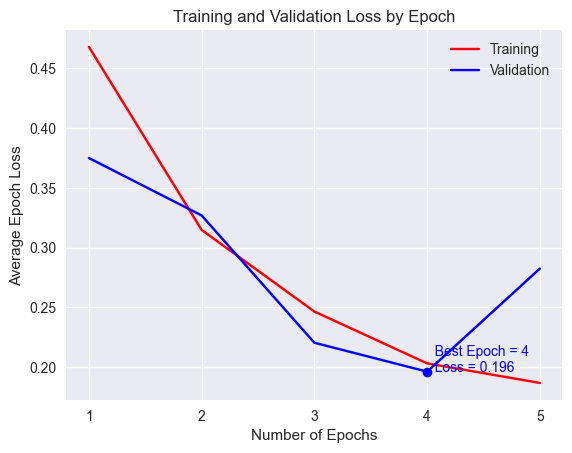

In [11]:
plotTrain(train_loss1, valid_loss1)

### ReLU + AvgPool

In [12]:
model2 = initModel('relu', 'avg', img_size, device, elu_val = 1, lrelu_val = .01)
model2.apply(w_init)
optimizer2 = optim.Adam(model2.parameters(), lr = lr)
train_loss2, valid_loss2 = trainModel(model2, 'relu', 'avg', img_size, train_loader, valid_loader, criterion, optimizer2, num_epochs, device)

[Epoch 1/5]
Mini-batch (i: 100): Average mini-batch loss: 0.698
Mini-batch (i: 200): Average mini-batch loss: 0.538
Mini-batch (i: 300): Average mini-batch loss: 0.462
Mini-batch (i: 400): Average mini-batch loss: 0.392
Mini-batch (i: 500): Average mini-batch loss: 0.395
End of Epoch 1 - train loss: 0.4871, valid loss: 0.7654
[Epoch 2/5]
Mini-batch (i: 100): Average mini-batch loss: 0.348
Mini-batch (i: 200): Average mini-batch loss: 0.346
Mini-batch (i: 300): Average mini-batch loss: 0.345
Mini-batch (i: 400): Average mini-batch loss: 0.329
Mini-batch (i: 500): Average mini-batch loss: 0.295
End of Epoch 2 - train loss: 0.3275, valid loss: 1.3378
[Epoch 3/5]
Mini-batch (i: 100): Average mini-batch loss: 0.290
Mini-batch (i: 200): Average mini-batch loss: 0.291
Mini-batch (i: 300): Average mini-batch loss: 0.273
Mini-batch (i: 400): Average mini-batch loss: 0.299
Mini-batch (i: 500): Average mini-batch loss: 0.263
End of Epoch 3 - train loss: 0.2809, valid loss: 0.4342
[Epoch 4/5]
Mini

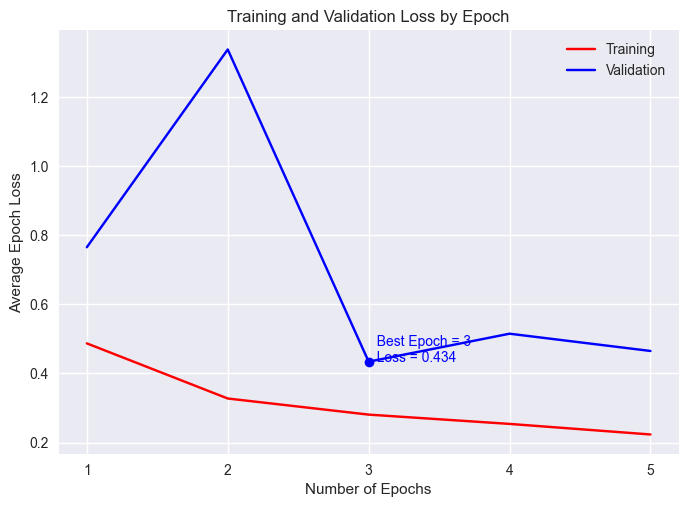

In [13]:
plotTrain(train_loss2, valid_loss2)

### LeakyReLU + MaxPool

In [14]:
model3 = initModel('lrelu', 'max', img_size, device, elu_val = 1, lrelu_val = .01)
optimizer3 = optim.Adam(model3.parameters(), lr = lr)
train_loss3, valid_loss3 = trainModel(model3, 'lrelu', 'max', img_size, train_loader, valid_loader, criterion, optimizer3, num_epochs, device)

[Epoch 1/5]
Mini-batch (i: 100): Average mini-batch loss: 0.675
Mini-batch (i: 200): Average mini-batch loss: 0.511
Mini-batch (i: 300): Average mini-batch loss: 0.429
Mini-batch (i: 400): Average mini-batch loss: 0.446
Mini-batch (i: 500): Average mini-batch loss: 0.406
End of Epoch 1 - train loss: 0.4811, valid loss: 0.5192
[Epoch 2/5]
Mini-batch (i: 100): Average mini-batch loss: 0.335
Mini-batch (i: 200): Average mini-batch loss: 0.314
Mini-batch (i: 300): Average mini-batch loss: 0.319
Mini-batch (i: 400): Average mini-batch loss: 0.314
Mini-batch (i: 500): Average mini-batch loss: 0.262
End of Epoch 2 - train loss: 0.3058, valid loss: 0.4710
[Epoch 3/5]
Mini-batch (i: 100): Average mini-batch loss: 0.276
Mini-batch (i: 200): Average mini-batch loss: 0.266
Mini-batch (i: 300): Average mini-batch loss: 0.244
Mini-batch (i: 400): Average mini-batch loss: 0.235
Mini-batch (i: 500): Average mini-batch loss: 0.226
End of Epoch 3 - train loss: 0.2468, valid loss: 0.4985
[Epoch 4/5]
Mini

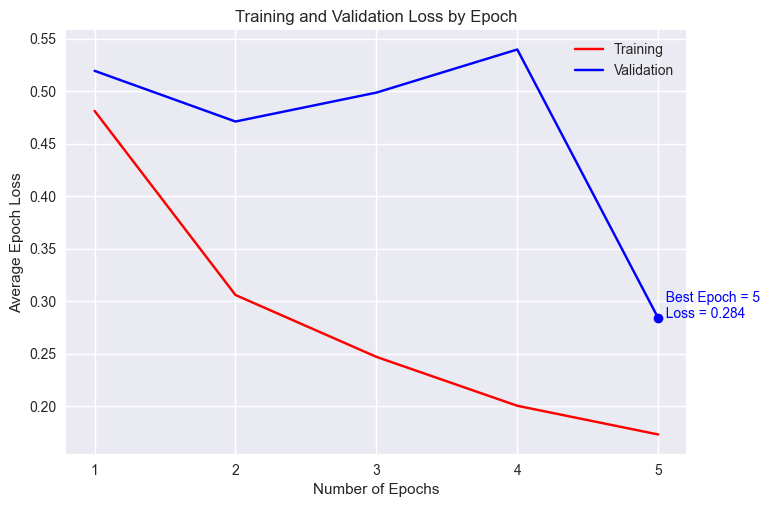

In [15]:
plotTrain(train_loss3, valid_loss3)

### LeakyReLU + AvgPool

In [16]:
model4 = initModel('relu', 'avg', img_size, device, elu_val = 1, lrelu_val = .01)
optimizer4 = optim.Adam(model4.parameters(), lr = lr)
train_loss4, valid_loss4 = trainModel(model4, 'lrelu', 'avg', img_size, train_loader, valid_loader, criterion, optimizer4, num_epochs, device)

[Epoch 1/5]
Mini-batch (i: 100): Average mini-batch loss: 0.692
Mini-batch (i: 200): Average mini-batch loss: 0.538
Mini-batch (i: 300): Average mini-batch loss: 0.481
Mini-batch (i: 400): Average mini-batch loss: 0.418
Mini-batch (i: 500): Average mini-batch loss: 0.378
End of Epoch 1 - train loss: 0.4878, valid loss: 0.9942
[Epoch 2/5]
Mini-batch (i: 100): Average mini-batch loss: 0.330
Mini-batch (i: 200): Average mini-batch loss: 0.301
Mini-batch (i: 300): Average mini-batch loss: 0.294
Mini-batch (i: 400): Average mini-batch loss: 0.299
Mini-batch (i: 500): Average mini-batch loss: 0.296
End of Epoch 2 - train loss: 0.3015, valid loss: 0.4583
[Epoch 3/5]
Mini-batch (i: 100): Average mini-batch loss: 0.253
Mini-batch (i: 200): Average mini-batch loss: 0.251
Mini-batch (i: 300): Average mini-batch loss: 0.239
Mini-batch (i: 400): Average mini-batch loss: 0.255
Mini-batch (i: 500): Average mini-batch loss: 0.241
End of Epoch 3 - train loss: 0.2509, valid loss: 0.5673
[Epoch 4/5]
Mini

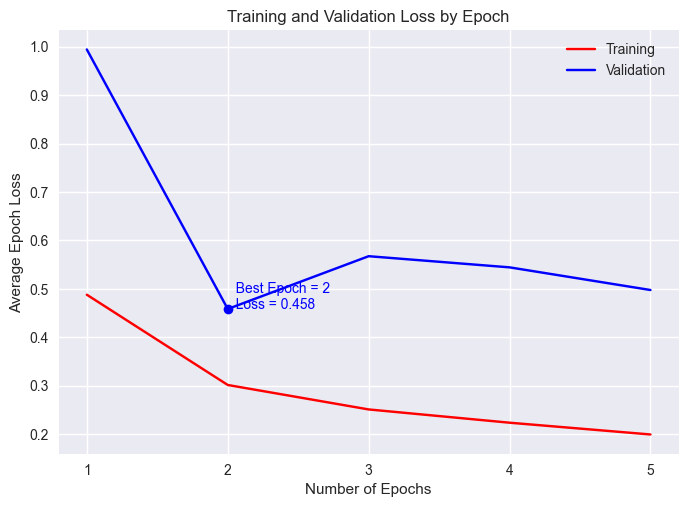

In [17]:
plotTrain(train_loss4, valid_loss4)

### ELU + MaxPool

In [20]:
model5 = initModel('elu', 'max', img_size, device, elu_val = 1, lrelu_val = .01)
optimizer5 = optim.Adam(model5.parameters(), lr = lr)
train_loss5, valid_loss5 = trainModel(model5, 'elu', 'max', img_size, train_loader, valid_loader, criterion, optimizer5, num_epochs, device)

[Epoch 1/5]
Mini-batch (i: 100): Average mini-batch loss: 0.676
Mini-batch (i: 200): Average mini-batch loss: 0.477
Mini-batch (i: 300): Average mini-batch loss: 0.415
Mini-batch (i: 400): Average mini-batch loss: 0.377
Mini-batch (i: 500): Average mini-batch loss: 0.385
End of Epoch 1 - train loss: 0.4502, valid loss: 0.8342
[Epoch 2/5]
Mini-batch (i: 100): Average mini-batch loss: 0.305
Mini-batch (i: 200): Average mini-batch loss: 0.313
Mini-batch (i: 300): Average mini-batch loss: 0.305
Mini-batch (i: 400): Average mini-batch loss: 0.271
Mini-batch (i: 500): Average mini-batch loss: 0.248
End of Epoch 2 - train loss: 0.2878, valid loss: 0.2958
[Epoch 3/5]
Mini-batch (i: 100): Average mini-batch loss: 0.260
Mini-batch (i: 200): Average mini-batch loss: 0.245
Mini-batch (i: 300): Average mini-batch loss: 0.232
Mini-batch (i: 400): Average mini-batch loss: 0.241
Mini-batch (i: 500): Average mini-batch loss: 0.216
End of Epoch 3 - train loss: 0.2340, valid loss: 0.2291
[Epoch 4/5]
Mini

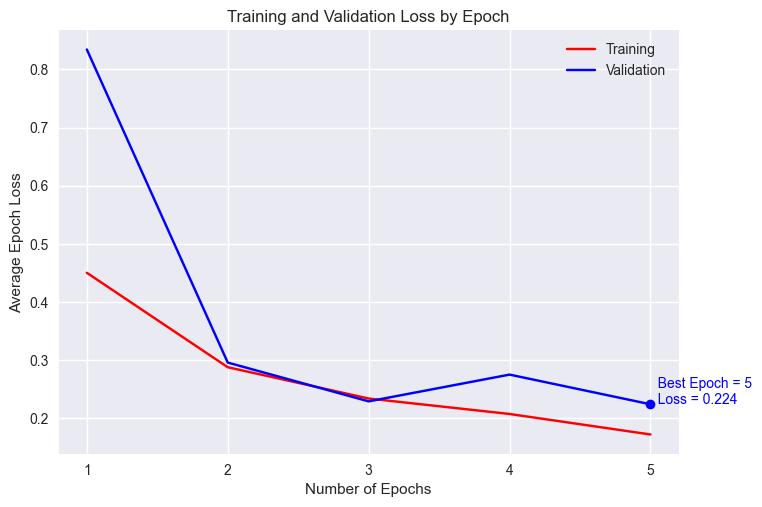

In [21]:
plotTrain(train_loss5, valid_loss5)

### ELU + AvgPool

In [22]:
model6 = initModel('elu', 'avg', img_size, device, elu_val = 1, lrelu_val = .01)
optimizer6 = optim.Adam(model6.parameters(), lr = lr)
train_loss6, valid_loss6 = trainModel(model6, 'elu', 'avg', img_size, train_loader, valid_loader, criterion, optimizer6, num_epochs, device)

[Epoch 1/5]
Mini-batch (i: 100): Average mini-batch loss: 0.651
Mini-batch (i: 200): Average mini-batch loss: 0.520
Mini-batch (i: 300): Average mini-batch loss: 0.435
Mini-batch (i: 400): Average mini-batch loss: 0.394
Mini-batch (i: 500): Average mini-batch loss: 0.359
End of Epoch 1 - train loss: 0.4641, valid loss: 0.5490
[Epoch 2/5]
Mini-batch (i: 100): Average mini-batch loss: 0.321
Mini-batch (i: 200): Average mini-batch loss: 0.292
Mini-batch (i: 300): Average mini-batch loss: 0.320
Mini-batch (i: 400): Average mini-batch loss: 0.284
Mini-batch (i: 500): Average mini-batch loss: 0.272
End of Epoch 2 - train loss: 0.2968, valid loss: 0.6813
[Epoch 3/5]
Mini-batch (i: 100): Average mini-batch loss: 0.257
Mini-batch (i: 200): Average mini-batch loss: 0.281
Mini-batch (i: 300): Average mini-batch loss: 0.256
Mini-batch (i: 400): Average mini-batch loss: 0.276
Mini-batch (i: 500): Average mini-batch loss: 0.273
End of Epoch 3 - train loss: 0.2691, valid loss: 0.3517
[Epoch 4/5]
Mini

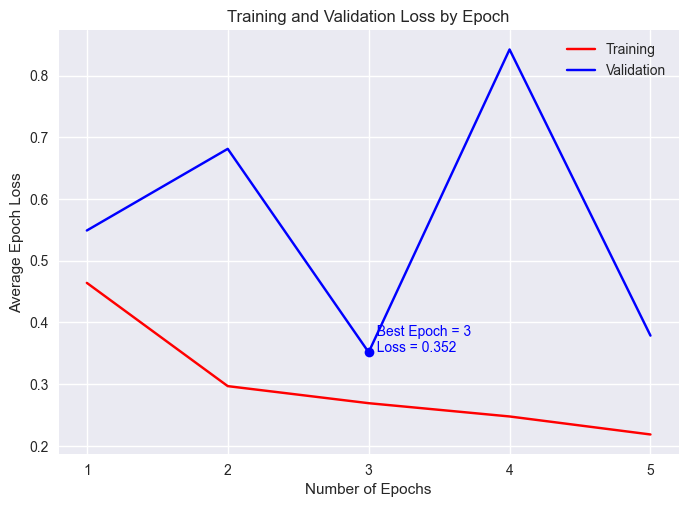

In [23]:
plotTrain(train_loss6, valid_loss6)

## **Evaluate on Testing Data**

In [24]:
flattened_labels = []
for data, labels in test_loader:
    flattened_labels.extend(labels.tolist())

### ReLU + MaxPool

Accuracy for colon_aca: 85.8%
Accuracy for colon_n: 82.0%
Accuracy for lung_aca: 76.5%
Accuracy for lung_n: 95.7%
Accuracy for lung_scc: 98.2%
Overall Model Accuracy: 87.6%


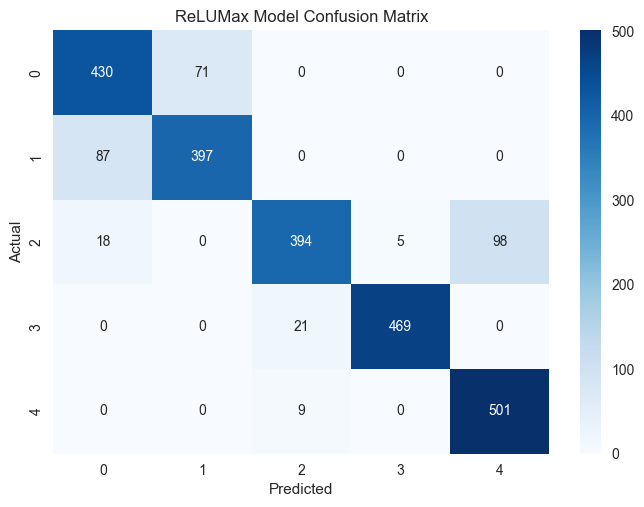

In [25]:
_, _, preds1 = loadModel('relu', 'max', img_size, test_loader, classes, device)
confMtx(preds1, flattened_labels, 'ReLU', 'Max')

### ReLU + AvgPool

In [26]:
_, _, preds2 = loadModel('relu', 'avg', img_size, test_loader, classes, device)
confMtx(preds2, flattened_labels, 'ReLU', 'Avg')

### LeakyReLU + MaxPool

In [ ]:
_, _, preds3 = loadModel('lrelu', 'max', img_size, test_loader, classes, device)
confMtx(preds3, flattened_labels, 'LReLU', 'MaxPool')

### LeakyReLU + AvgPool

In [ ]:
_, _, preds4 = loadModel('lrelu', 'avg', img_size, test_loader, classes, device)
confMtx(preds4, flattened_labels, 'LReLU', 'AvgPool')

### ELU + MaxPool

In [ ]:
_, _, preds5 = loadModel('elu', 'max', img_size, test_loader, classes, device)
confMtx(preds5, flattened_labels, 'ELU', 'MaxPool')

### ELU + AvgPool

In [ ]:
_, _, preds6 = loadModel('elu', 'avg', img_size, test_loader, classes, device)
confMtx(preds6, flattened_labels, 'ELU', 'AvgPool')

## **Comparison to other popular CNN Architectures**

Any other popular architectures (feel free to edit / we can decide together)

In [ ]:
num_epochs = 5
criterion = nn.CrossEntropyLoss()
lr = 0.001
num_classes = len(classes)

### ResNet18

In [ ]:
model = ResNet18(num_classes, img_size)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss, valid_loss = trainModel(model, None, None, img_size, train_loader, valid_loader, criterion, optimizer, num_epochs, device)
saveModel(model, 'resnet18')

[Epoch 1/5]
Mini-batch (i: 100): Average mini-batch loss: 0.283
Mini-batch (i: 200): Average mini-batch loss: 0.123
Mini-batch (i: 300): Average mini-batch loss: 0.151
Mini-batch (i: 400): Average mini-batch loss: 0.111
Mini-batch (i: 500): Average mini-batch loss: 0.109
End of Epoch 1 - train loss: 0.1509, valid loss: 0.1660
[Epoch 2/5]
Mini-batch (i: 100): Average mini-batch loss: 0.085
Mini-batch (i: 200): Average mini-batch loss: 0.155
Mini-batch (i: 300): Average mini-batch loss: 0.075
Mini-batch (i: 400): Average mini-batch loss: 0.075
Mini-batch (i: 500): Average mini-batch loss: 0.065
End of Epoch 2 - train loss: 0.0891, valid loss: 0.0772
[Epoch 3/5]
Mini-batch (i: 100): Average mini-batch loss: 0.066
Mini-batch (i: 200): Average mini-batch loss: 0.070
Mini-batch (i: 300): Average mini-batch loss: 0.052
Mini-batch (i: 400): Average mini-batch loss: 0.056
Mini-batch (i: 500): Average mini-batch loss: 0.048
End of Epoch 3 - train loss: 0.0563, valid loss: 0.0558
[Epoch 4/5]
Mini

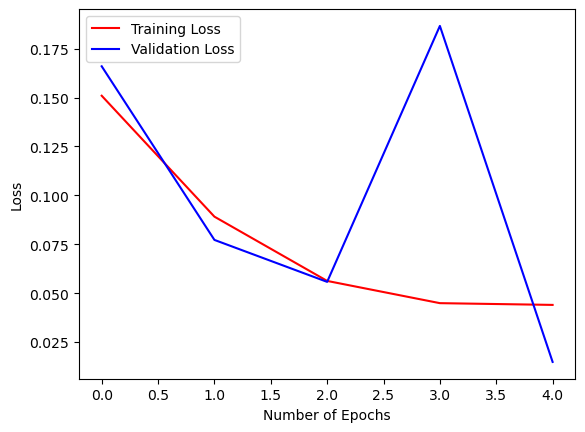

In [ ]:
plotTrain(train_loss, valid_loss)

In [ ]:
_ , _ = testNN(model, test_loader, classes, device)

Accuracy for colon_aca: 99.2%
Accuracy for colon_n: 99.8%
Accuracy for lung_aca: 99.0%
Accuracy for lung_n: 99.8%
Accuracy for lung_scc: 100.0%
Overall Model Accuracy: 99.6%


### EfficientNet_V2_S

In [ ]:
model = EfficientNet_V2_S(num_classes, img_size)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss, valid_loss = trainModel(model, None, None, img_size, train_loader, valid_loader, criterion, optimizer, num_epochs, device)
saveModel(model, 'effnetV2_S')

[Epoch 1/5]
Mini-batch (i: 100): Average mini-batch loss: 0.269
Mini-batch (i: 200): Average mini-batch loss: 0.147
Mini-batch (i: 300): Average mini-batch loss: 0.120
Mini-batch (i: 400): Average mini-batch loss: 0.099
Mini-batch (i: 500): Average mini-batch loss: 0.068
End of Epoch 1 - train loss: 0.1345, valid loss: 0.0300
[Epoch 2/5]
Mini-batch (i: 100): Average mini-batch loss: 0.081
Mini-batch (i: 200): Average mini-batch loss: 0.068
Mini-batch (i: 300): Average mini-batch loss: 0.050
Mini-batch (i: 400): Average mini-batch loss: 0.062
Mini-batch (i: 500): Average mini-batch loss: 0.046
End of Epoch 2 - train loss: 0.0623, valid loss: 0.0555
[Epoch 3/5]
Mini-batch (i: 100): Average mini-batch loss: 0.065
Mini-batch (i: 200): Average mini-batch loss: 0.026
Mini-batch (i: 300): Average mini-batch loss: 0.038
Mini-batch (i: 400): Average mini-batch loss: 0.033
Mini-batch (i: 500): Average mini-batch loss: 0.051
End of Epoch 3 - train loss: 0.0422, valid loss: 0.0329
[Epoch 4/5]
Mini

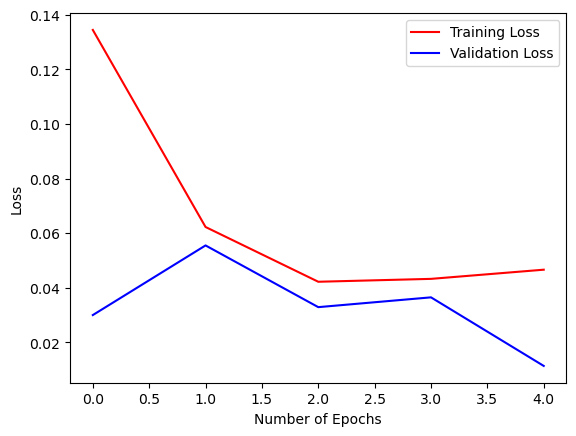

In [ ]:
plotTrain(train_loss, valid_loss)

In [ ]:
_ , _ = testNN(model, test_loader, classes, device)

Accuracy for colon_aca: 100.0%
Accuracy for colon_n: 100.0%
Accuracy for lung_aca: 99.0%
Accuracy for lung_n: 100.0%
Accuracy for lung_scc: 99.8%
Overall Model Accuracy: 99.8%


### VGG11_BN

In [ ]:
model = VGG11_bn(num_classes, img_size)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss, valid_loss = trainModel(model, None, None, img_size, train_loader, valid_loader, criterion, optimizer, num_epochs, device)
saveModel(model, 'vgg11_bn')

[Epoch 1/5]
Mini-batch (i: 100): Average mini-batch loss: 0.500
Mini-batch (i: 200): Average mini-batch loss: 0.289
Mini-batch (i: 300): Average mini-batch loss: 0.264
Mini-batch (i: 400): Average mini-batch loss: 0.369
Mini-batch (i: 500): Average mini-batch loss: 0.357
End of Epoch 1 - train loss: 0.3565, valid loss: 0.2079
[Epoch 2/5]
Mini-batch (i: 100): Average mini-batch loss: 0.273
Mini-batch (i: 200): Average mini-batch loss: 0.226
Mini-batch (i: 300): Average mini-batch loss: 0.224
Mini-batch (i: 400): Average mini-batch loss: 0.157
Mini-batch (i: 500): Average mini-batch loss: 0.258
End of Epoch 2 - train loss: 0.2218, valid loss: 0.0875
[Epoch 3/5]
Mini-batch (i: 100): Average mini-batch loss: 0.155
Mini-batch (i: 200): Average mini-batch loss: 0.121
Mini-batch (i: 300): Average mini-batch loss: 1.256
Mini-batch (i: 400): Average mini-batch loss: 0.505
Mini-batch (i: 500): Average mini-batch loss: 0.218
End of Epoch 3 - train loss: 0.4287, valid loss: 0.1459
[Epoch 4/5]
Mini

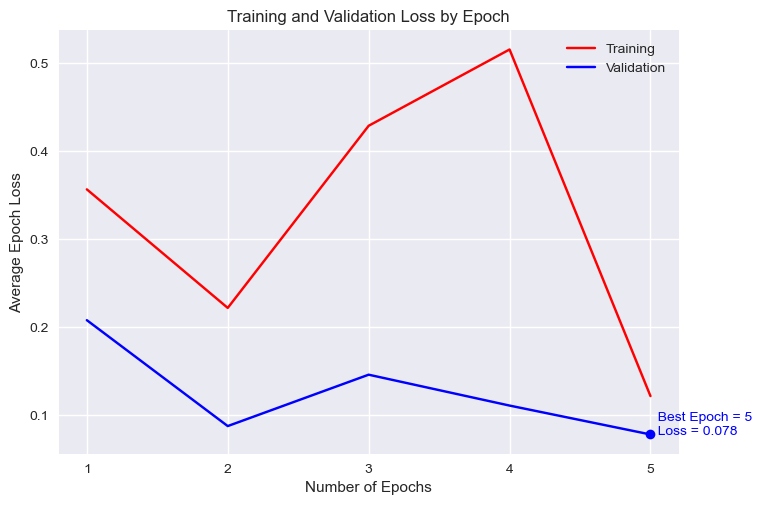

In [ ]:
plotTrain(train_loss, valid_loss)

In [ ]:
_ , _ = testNN(model, test_loader, classes, device)

Accuracy for colon_aca: 100.0%
Accuracy for colon_n: 99.8%
Accuracy for lung_aca: 92.9%
Accuracy for lung_n: 99.6%
Accuracy for lung_scc: 99.0%
Overall Model Accuracy: 98.3%
